### Cell 1: Setup & pick one processed FIF and one (or more) original EDF(s)

In [1]:
from pathlib import Path

# Resolve repo root whether running from repo root or notebooks/
ROOT = Path.cwd()
if ROOT.name.lower() == "notebooks":
    ROOT = ROOT.parent
print("Repo root:", ROOT)

# Folders (adjust if your structure differs)
PROCESSED_DIR = ROOT / "data" / "used_raws"     # cleaned/processed MNE FIF files (C&K subset)
EDF_DIR        = ROOT / "EDF filer"             # original EDF files

# ------------------------------------------------------------------------------------
# >>> SELECT YOUR FILES HERE <<<
# Choose ONE processed .fif filename AND ONE OR MORE original .edf filenames to compare.
# Tip: You can put a single EDF name (["10GK-EDF+1.edf"]) or multiple pieces (["10GK-EDF+.edf","10GK-EDF+1.edf"]).
PROCESSED_NAME = "patient10_raw.fif"
EDF_NAMES      = ["10GK-EDF+.edf", "10GK-EDF+1.edf"]
# ------------------------------------------------------------------------------------

# Resolve the selected paths
processed_path = (PROCESSED_DIR / PROCESSED_NAME).resolve()
edf_paths = [(EDF_DIR / n).resolve() for n in EDF_NAMES]

# Basic validation + helpful messages
errors = []
if not processed_path.exists():
    errors.append(f"[!] Processed file not found: {processed_path}")
for p in edf_paths:
    if not p.exists():
        errors.append(f"[!] EDF file not found: {p}")

if errors:
    print("\n".join(errors))
    # List available files to help selection
    if not processed_path.exists() and PROCESSED_DIR.exists():
        print("\nAvailable processed FIF files:")
        for p in sorted(PROCESSED_DIR.glob("*.fif")):
            print(" -", p.name)
    if any(not p.exists() for p in edf_paths) and EDF_DIR.exists():
        print("\nAvailable original EDF files (first 50 shown):")
        for i, p in enumerate(sorted(EDF_DIR.glob("*.edf"), key=lambda x: x.name)[:50], 1):
            print(f"{i:2d}.", p.name)
    raise FileNotFoundError("Please fix the selections above (PROCESSED_NAME / EDF_NAMES).")

print("\nSelections:")
print("  Processed FIF:", processed_path)
print("  Original EDFs:")
for p in edf_paths:
    print("   -", p)

# Keep handles for next cells
PROCESSED_PATH = processed_path
ORIGINAL_EDF_PATHS = edf_paths
print("\nReady for Cell 2 (loading & metadata sanity-check).")


Repo root: l:\AuditData\CONNECT-ME\Bjoern\eeg-bachelor

Selections:
  Processed FIF: \\regionh.top.local\dfs\Logget\AuditData\CONNECT-ME\Bjoern\eeg-bachelor\data\used_raws\patient10_raw.fif
  Original EDFs:
   - \\regionh.top.local\dfs\Logget\AuditData\CONNECT-ME\Bjoern\eeg-bachelor\EDF filer\10GK-EDF+.edf
   - \\regionh.top.local\dfs\Logget\AuditData\CONNECT-ME\Bjoern\eeg-bachelor\EDF filer\10GK-EDF+1.edf

Ready for Cell 2 (loading & metadata sanity-check).


### Cell 2: Load both selections and print a side-by-side metadata summary

In [2]:
from pathlib import Path
from collections import Counter
import numpy as np
import mne
import math
import datetime as dt

# Guards (require selections from Cell 1)
assert 'PROCESSED_PATH' in globals() and Path(PROCESSED_PATH).exists(), "Run Cell 1 and fix PROCESSED_NAME."
assert 'ORIGINAL_EDF_PATHS' in globals() and all(Path(p).exists() for p in ORIGINAL_EDF_PATHS), "Run Cell 1 and fix EDF_NAMES."

def normalize_ch_name(name: str) -> str:
    """
    Normalize clinical EEG channel names so 'EEG Fp1-REF' -> 'FP1'.
    This helps matching channel sets between EDF and FIF.
    """
    s = name.upper().strip()
    if s.startswith("EEG "):
        s = s[4:]
    for suff in ("-REF", "-LE", "-A1", "-A2", "-M1", "-M2", "-CZ"):
        if s.endswith(suff):
            s = s[: -len(suff)]
    s = s.replace(" ", "").replace("-", "")
    return s

def summarize_raw(raw: mne.io.BaseRaw, label: str):
    """Compact, readable summary of an MNE Raw object."""
    info = raw.info
    sfreq = float(info["sfreq"])
    duration_sec = raw.n_times / sfreq if sfreq else float("nan")
    eeg_picks = mne.pick_types(info, eeg=True, eog=False, meg=False)
    try:
        montage = raw.get_montage()
        montage_name = getattr(montage, "kind", None) or getattr(montage, "name", None) or type(montage).__name__
    except Exception:
        montage_name = None
    print(f"=== {label} ===")
    print(f"Channels: {info['nchan']}  (EEG picks: {len(eeg_picks)})")
    print(f"Sampling rate: {sfreq:g} Hz")
    print(f"Duration: {duration_sec/60:.1f} min ({duration_sec:.1f} s)")
    print(f"Montage: {montage_name}")
    print(f"High/Low-pass (info): {info.get('highpass', None)} / {info.get('lowpass', None)}")
    print(f"Bad channels ({len(info.get('bads', []) or [])}): {info.get('bads', [])}")
    # Annotations preview
    ann_counter = Counter()
    if getattr(raw, "annotations", None) is not None and len(raw.annotations) > 0:
        for desc in raw.annotations.description:
            ann_counter[desc] += 1
        top = ", ".join([f"{k}: {v}" for k, v in ann_counter.most_common(6)])
        print("Annotations (top):", top)
    # Channel name preview
    print("First channel names:", info["ch_names"][:10])
    print()

# Load processed FIF (fast header read)
RAW_FIF = mne.io.read_raw_fif(str(PROCESSED_PATH), preload=False, verbose=False)
summarize_raw(RAW_FIF, f"Processed FIF: {PROCESSED_PATH.name}")

# Load all selected EDF parts (header only)
edf_raws = []
for p in ORIGINAL_EDF_PATHS:
    r = mne.io.read_raw_edf(str(p), preload=False, verbose=False)
    edf_raws.append(r)
    summarize_raw(r, f"Original EDF: {Path(p).name}")

# Aggregate EDF metadata across parts
def edf_aggregate(raws):
    """Return combined duration (sum), common sfreq (assert equal), and union EEG channel set."""
    if not raws:
        return math.nan, set(), math.nan
    # Ensure same sampling rate across parts (common in Nicolet exports)
    sf = float(raws[0].info["sfreq"])
    if any(abs(float(r.info["sfreq"]) - sf) > 1e-6 for r in raws):
        print("[!] Warning: EDF parts have different sampling rates.")
    # Sum durations
    total_sec = sum(r.n_times / float(r.info["sfreq"]) for r in raws)
    # Union of EEG channels (normalized)
    union_norm = set()
    for r in raws:
        picks = mne.pick_types(r.info, eeg=True, eog=False, meg=False)
        chs = [r.info["ch_names"][i] for i in picks]
        union_norm |= {normalize_ch_name(c) for c in chs}
    return total_sec, union_norm, sf

edf_total_sec, edf_union_norm, edf_sfreq = edf_aggregate(edf_raws)

# FIF EEG channels (normalized)
fif_eeg_picks = mne.pick_types(RAW_FIF.info, eeg=True, eog=False, meg=False)
fif_eeg = [RAW_FIF.info["ch_names"][i] for i in fif_eeg_picks]
fif_norm = {normalize_ch_name(c) for c in fif_eeg}

# Overlap metrics
overlap = sorted(fif_norm & edf_union_norm)
missing_in_edf = sorted(fif_norm - edf_union_norm)
extra_in_edf = sorted(edf_union_norm - fif_norm)

# Durations
fif_sec = RAW_FIF.n_times / float(RAW_FIF.info["sfreq"])
delta_sec = abs(edf_total_sec - fif_sec)

print("=== Combined original EDF(s) summary ===")
print(f"EDF parts: {len(edf_raws)}  -> concatenated duration ≈ {edf_total_sec/60:.2f} min ({edf_total_sec:.1f} s)")
print(f"Sampling rate (EDF): {edf_sfreq:g} Hz")
print(f"EEG channels (union, normalized): {len(edf_union_norm)}")
print("\n=== Side-by-side diff (Processed FIF vs. Original EDFs) ===")
print(f"Sampling rate: {RAW_FIF.info['sfreq']:g} Hz  vs  {edf_sfreq:g} Hz")
print(f"Duration:      {fif_sec/60:.2f} min ({fif_sec:.1f} s)  vs  {edf_total_sec/60:.2f} min ({edf_total_sec:.1f} s)")
print(f"|Δduration|:   {delta_sec:.3f} s")
print(f"EEG overlap:   {len(overlap)} / {len(fif_norm)} channels match (normalized).")
print("Matched (first 12):", overlap[:12])
if missing_in_edf:
    print("Missing in EDF:", missing_in_edf)
if extra_in_edf:
    print("Extra in EDF  :", extra_in_edf[:15], ("..." if len(extra_in_edf) > 15 else ""))

# Keep handles for later cells
EDF_RAWS = edf_raws
EDF_TOTAL_DURATION_S = edf_total_sec
EDF_SFREQ = edf_sfreq
FIF_DURATION_S = fif_sec


=== Processed FIF: patient10_raw.fif ===
Channels: 20  (EEG picks: 19)
Sampling rate: 250 Hz
Duration: 83.4 min (5003.7 s)
Montage: DigMontage
High/Low-pass (info): 0.10000000149011612 / 45.0
Bad channels (0): []
Annotations (top): Familiar voice: 10, Medical staff: 10, Resting: 3, Montage is now: ComAvg: 2, Impedance: 1, Detections Inactive: 1
First channel names: ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2']

=== Original EDF: 10GK-EDF+.edf ===
Channels: 25  (EEG picks: 25)
Sampling rate: 250 Hz
Duration: 2.8 min (165.0 s)
Montage: NoneType
High/Low-pass (info): 0.0 / 125.0
Bad channels (0): []
Annotations (top): Montage is now: ComAvg: 2, Impedance: 1, Detections Inactive: 1, øjne lukkede under optagelsen: 1, Montage is now: Long: 1, Montage is now: Trans: 1
First channel names: ['EEG Fp1-REF', 'EEG Fp2-REF', 'EEG F3-REF', 'EEG F4-REF', 'EEG C3-REF', 'EEG C4-REF', 'EEG P3-REF', 'EEG P4-REF', 'EEG O1-REF', 'EEG O2-REF']

=== Original EDF: 10GK-EDF+1.edf ===
Channels:

### Cell 3: Common channels and 10 s “Resting” windows (np meta-prints)

In [3]:
import re
import numpy as np
import mne
from pathlib import Path

# Helpers (defined if missing)
try:
    normalize_ch_name
except NameError:
    def normalize_ch_name(name: str) -> str:
        s = name.upper().strip()
        if s.startswith("EEG "):
            s = s[4:]
        for suff in ("-REF", "-LE", "-A1", "-A2", "-M1", "-M2", "-CZ"):
            if s.endswith(suff):
                s = s[: -len(suff)]
        s = s.replace(" ", "").replace("-", "")
        return s

def find_first_onset(raw, keywords=("Resting",)):
    if getattr(raw, "annotations", None) is None or len(raw.annotations) == 0:
        return None
    pattern = re.compile("|".join(map(re.escape, keywords)), re.IGNORECASE)
    for onset, _, desc in zip(raw.annotations.onset, raw.annotations.duration, raw.annotations.description):
        if pattern.search(desc or ""):
            return float(onset)
    return None

def clamp_window(raw, t0, length=10.0):
    sf = float(raw.info["sfreq"])
    total = raw.n_times / sf if sf else 0.0
    if t0 is None or not np.isfinite(t0) or t0 < 0:
        t0 = 60.0 if total > 70.0 else 0.0
    t0 = max(0.0, min(t0, max(0.0, total - length)))
    return (t0, min(total, t0 + length))

# Require data loaded in Cell 2
assert 'RAW_FIF' in globals(), "Load the processed FIF in Cell 2."
assert 'EDF_RAWS' in globals() and len(EDF_RAWS) > 0, "Load the original EDF(s) in Cell 2."

# Build ordered common EEG channel lists (keep FIF order for stability)
fif_eeg_picks = mne.pick_types(RAW_FIF.info, eeg=True, eog=False, meg=False)
fif_eeg_names = [RAW_FIF.info["ch_names"][i] for i in fif_eeg_picks]
fif_norm_map = {normalize_ch_name(c): c for c in fif_eeg_names}

edf_norm_map = {}
for r in EDF_RAWS:
    picks = mne.pick_types(r.info, eeg=True, eog=False, meg=False)
    for c in [r.info["ch_names"][i] for i in picks]:
        n = normalize_ch_name(c)
        if n not in edf_norm_map:
            edf_norm_map[n] = c

common_norm = [normalize_ch_name(c) for c in fif_eeg_names if normalize_ch_name(c) in edf_norm_map]
COMMON_FIF_NAMES = [fif_norm_map[n] for n in common_norm]
COMMON_EDF_NAMES = [edf_norm_map[n] for n in common_norm]

print(f"Common EEG channels: {len(common_norm)} / {len(fif_eeg_names)}")
print("First 12 (normalized):", common_norm[:12])

# Choose 10 s windows around first 'Resting' (with robust fallbacks)
fif_onset = find_first_onset(RAW_FIF, keywords=("Resting",))
FIF_WIN = clamp_window(RAW_FIF, fif_onset, length=10.0)

edf_choice_idx, edf_onset = 0, None
for idx, r in enumerate(EDF_RAWS):
    onset = find_first_onset(r, keywords=("Resting",))
    if onset is not None:
        edf_choice_idx, edf_onset = idx, onset
        break
EDF_RAW_FOR_SNIPPET = EDF_RAWS[edf_choice_idx]
EDF_WIN = clamp_window(EDF_RAW_FOR_SNIPPET, edf_onset, length=10.0)

print(f"FIF window (s): {FIF_WIN[0]:.2f}–{FIF_WIN[1]:.2f}")
print(f"EDF window (s): {EDF_WIN[0]:.2f}–{EDF_WIN[1]:.2f} (from {Path(ORIGINAL_EDF_PATHS[edf_choice_idx]).name})")


Common EEG channels: 19 / 19
First 12 (normalized): ['FP1', 'FP2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8']
FIF window (s): 173.66–183.66
EDF window (s): 38.47–48.47 (from 10GK-EDF+.edf)


### Cell 4: 10 s snippets on common channels + quick comparisons (time series & PSD)

Reading 0 ... 41249  =      0.000 ...   164.996 secs...


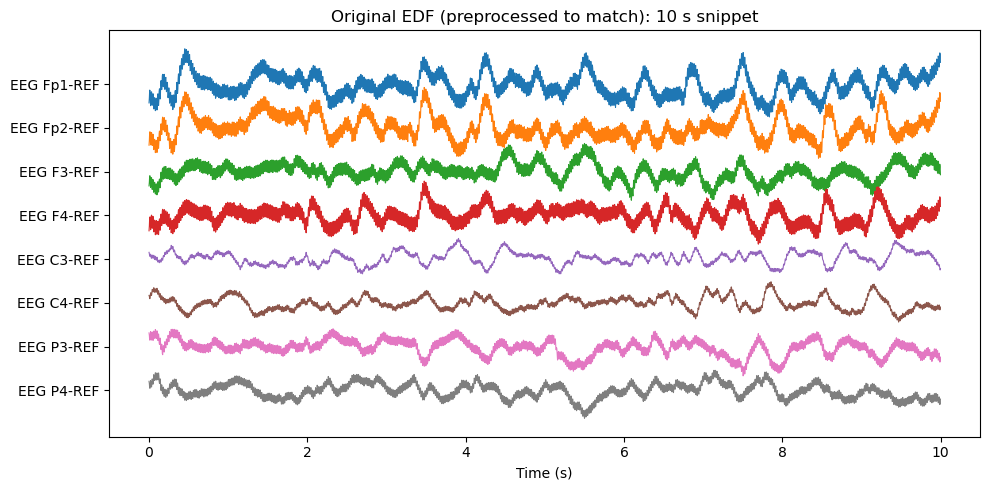

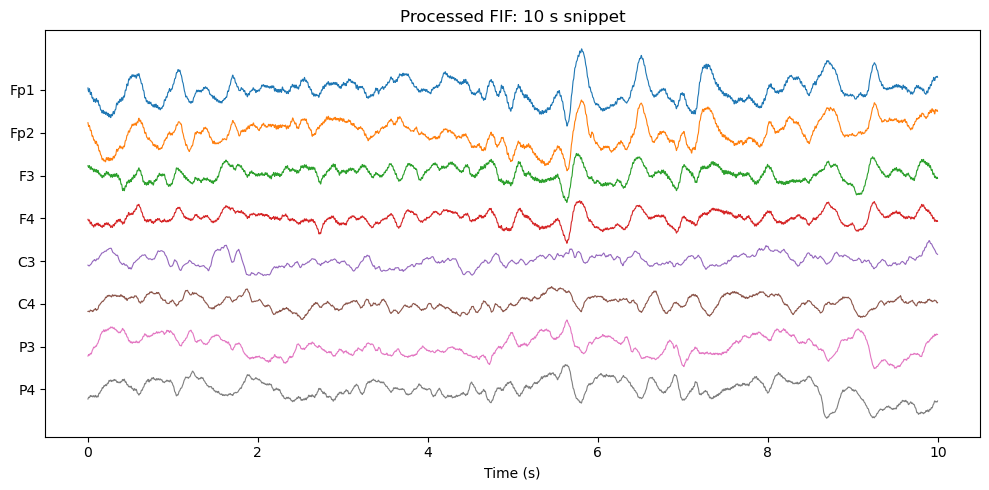

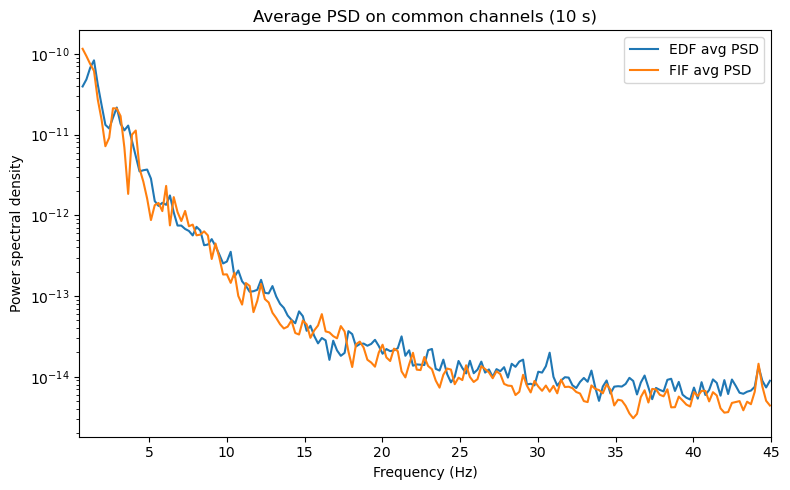

In [4]:
import numpy as np
import mne
import matplotlib.pyplot as plt
from mne.time_frequency import psd_array_welch

# Requirements from previous cells
assert 'RAW_FIF' in globals() and 'EDF_RAW_FOR_SNIPPET' in globals()
assert 'COMMON_FIF_NAMES' in globals() and 'COMMON_EDF_NAMES' in globals()
assert 'FIF_WIN' in globals() and 'EDF_WIN' in globals()

# 1) FIF snippet (already cleaned/avg-ref + 0.1–45 Hz in metadata)
raw_fif_snip = RAW_FIF.copy()
raw_fif_snip.pick(COMMON_FIF_NAMES)
raw_fif_snip.crop(tmin=FIF_WIN[0], tmax=FIF_WIN[1], include_tmax=False)
sf_fif = float(raw_fif_snip.info["sfreq"])
data_fif = raw_fif_snip.get_data()               # (n_ch, n_samples)
times_fif = np.arange(raw_fif_snip.n_times) / sf_fif

# 2) EDF snippet with lightweight preprocessing to match FIF (0.1–45 Hz, avg-ref)
raw_edf_snip = EDF_RAW_FOR_SNIPPET.copy()
raw_edf_snip.pick(COMMON_EDF_NAMES)
raw_edf_snip.load_data()
raw_edf_snip.filter(l_freq=0.1, h_freq=45.0, picks='eeg', phase='zero', verbose=False)
raw_edf_snip.set_eeg_reference('average', projection=False, verbose=False)
raw_edf_snip.crop(tmin=EDF_WIN[0], tmax=EDF_WIN[1], include_tmax=False)
sf_edf = float(raw_edf_snip.info["sfreq"])
data_edf = raw_edf_snip.get_data()
times_edf = np.arange(raw_edf_snip.n_times) / sf_edf

# 3) Stacked time-series plots (first 8 common channels for readability)
max_ch_plot = min(8, data_fif.shape[0])
subset_idx = np.arange(max_ch_plot)

def stacked_plot(times, data, ch_names, title):
    # Robust per-plot scaling and vertical offsets
    scale = np.median(np.std(data[subset_idx, :], axis=1))
    scale = 1.0 if not np.isfinite(scale) or scale == 0 else scale
    offsets = np.arange(max_ch_plot)[::-1] * 5 * scale
    plt.figure(figsize=(10, 5))
    for i, idx in enumerate(subset_idx):
        plt.plot(times, data[idx, :] + offsets[i], linewidth=0.8)
    plt.yticks(offsets, [ch_names[i] for i in subset_idx])
    plt.xlabel("Time (s)")
    plt.title(title)
    plt.tight_layout()
    plt.show()

stacked_plot(times_edf, data_edf, raw_edf_snip.ch_names, "Original EDF (preprocessed to match): 10 s snippet")
stacked_plot(times_fif, data_fif, raw_fif_snip.ch_names, "Processed FIF: 10 s snippet")

# 4) Average PSD on common channels (0.5–45 Hz) using Welch
def compute_avg_psd(data, sfreq, n_fft=1024):
    # psd_array_welch returns (psds, freqs) with psds.shape == (n_channels, n_freqs)
    psds, freqs = psd_array_welch(
        data, sfreq=sfreq, n_fft=n_fft, n_overlap=n_fft // 2,
        fmin=0.5, fmax=45.0, average='mean', verbose=False
    )
    return freqs, psds.mean(axis=0)

freqs_edf, psd_edf = compute_avg_psd(data_edf, sf_edf)
freqs_fif, psd_fif = compute_avg_psd(data_fif, sf_fif)

plt.figure(figsize=(8, 5))
plt.semilogy(freqs_edf, psd_edf, label="EDF avg PSD")
plt.semilogy(freqs_fif, psd_fif, label="FIF avg PSD")
plt.xlim(0.5, 45.0)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power spectral density")
plt.title("Average PSD on common channels (10 s)")
plt.legend()
plt.tight_layout()
plt.show()


### Cell 5: Concatenate original EDFs, compute whole-recording average PSD vs. processed FIF

Common EEG channels: 19
Durations — FIF: 83.40 min | EDF (concat): 83.42 min
Sampling rate — FIF: 250 Hz | EDF: 250 Hz


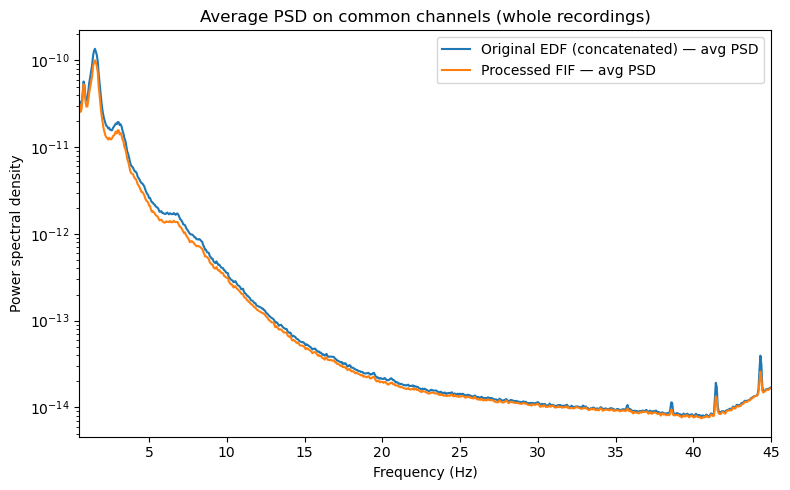

In [6]:
import numpy as np
import mne
import matplotlib.pyplot as plt
from mne.time_frequency import psd_array_welch
from pathlib import Path

# Preconditions
assert 'RAW_FIF' in globals() and 'ORIGINAL_EDF_PATHS' in globals()

# 1) Concatenate the selected original EDF parts into one recording
EDF_RAWS = [mne.io.read_raw_edf(str(p), preload=False, verbose=False) for p in ORIGINAL_EDF_PATHS]
RAW_EDF_ALL = mne.concatenate_raws([r.copy() for r in EDF_RAWS], verbose=False)

# 2) Helper: normalize clinical EEG channel names to compare sets
def normalize_ch_name(name: str) -> str:
    s = name.upper().strip()
    if s.startswith("EEG "):
        s = s[4:]
    for suff in ("-REF", "-LE", "-A1", "-A2", "-M1", "-M2", "-CZ"):
        if s.endswith(suff):
            s = s[: -len(suff)]
    return s.replace(" ", "").replace("-", "")

# 3) Build common EEG channel lists (keep FIF order)
fif_eeg_picks = mne.pick_types(RAW_FIF.info, eeg=True, eog=False, meg=False)
fif_eeg_names = [RAW_FIF.info["ch_names"][i] for i in fif_eeg_picks]
fif_norm_map  = {normalize_ch_name(c): c for c in fif_eeg_names}

edf_eeg_picks = mne.pick_types(RAW_EDF_ALL.info, eeg=True, eog=False, meg=False)
edf_eeg_names = [RAW_EDF_ALL.info["ch_names"][i] for i in edf_eeg_picks]
edf_norm_map  = {}
for c in edf_eeg_names:
    n = normalize_ch_name(c)
    if n not in edf_norm_map:
        edf_norm_map[n] = c

common_norm       = [normalize_ch_name(c) for c in fif_eeg_names if normalize_ch_name(c) in edf_norm_map]
COMMON_FIF_NAMES  = [fif_norm_map[n] for n in common_norm]
COMMON_EDF_NAMES  = [edf_norm_map[n] for n in common_norm]

print(f"Common EEG channels: {len(common_norm)}")

# 4) Prepare data
# FIF (already cleaned)
raw_fif_all = RAW_FIF.copy().pick(COMMON_FIF_NAMES)
sf_fif = float(raw_fif_all.info["sfreq"])
dur_fif = raw_fif_all.n_times / sf_fif
data_fif = raw_fif_all.get_data()  # loads lazily if needed

# EDF (lightweight preprocessing to roughly match FIF)
raw_edf_all = RAW_EDF_ALL.copy().pick(COMMON_EDF_NAMES)
raw_edf_all.load_data(verbose=False)
raw_edf_all.filter(l_freq=0.1, h_freq=45.0, picks='eeg', phase='zero', verbose=False)
raw_edf_all.set_eeg_reference('average', projection=False, verbose=False)
sf_edf = float(raw_edf_all.info["sfreq"])
dur_edf = raw_edf_all.n_times / sf_edf
data_edf = raw_edf_all.get_data()

print(f"Durations — FIF: {dur_fif/60:.2f} min | EDF (concat): {dur_edf/60:.2f} min")
print(f"Sampling rate — FIF: {sf_fif:g} Hz | EDF: {sf_edf:g} Hz")

# 5) Average PSD (Welch) on common channels for the full recordings
def avg_psd(data, sfreq, n_fft=4096):
    # Ensure n_fft is not larger than the segment length
    n_fft = min(n_fft, 2 ** int(np.floor(np.log2(data.shape[1]))))
    psds, freqs = psd_array_welch(
        data, sfreq=sfreq, n_fft=n_fft, n_overlap=n_fft // 2,
        fmin=0.5, fmax=45.0, average='mean', verbose=False
    )
    return freqs, psds.mean(axis=0)

freqs_edf, psd_edf = avg_psd(data_edf, sf_edf)
freqs_fif, psd_fif = avg_psd(data_fif, sf_fif)

# 6) Plot
plt.figure(figsize=(8, 5))
plt.semilogy(freqs_edf, psd_edf, label="Original EDF (concatenated) — avg PSD")
plt.semilogy(freqs_fif, psd_fif, label="Processed FIF — avg PSD")
plt.xlim(0.5, 45.0)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power spectral density")
plt.title("Average PSD on common channels (whole recordings)")
plt.legend()
plt.tight_layout()
plt.show()
